In [1]:
from autoray import numpy
import numpy as np
import quimb as qu
import quimb.tensor as qtn
from matplotlib import pyplot as plt
import scipy.stats as stats
import scipy
from distfit import distfit
import itertools

In [3]:
def gamma(d): return np.array([[1, 1/d, 1/d**0.5, 1/d**0.5, 1/d**1.5, 1/d**1.5, 1/d],
                                [1/d, 1, 1/d**1.5, 1/d**1.5, 1/d**0.5, 1/d**0.5, 1/d],
                                [1/d**0.5, 1/d**1.5, 1, 1/d, 1/d, 1/d, 1/d**0.5],
                                [1/d**0.5, 1/d**1.5, 1/d, 1, 1/d, 1/d, 1/d**0.5],
                                [1/d**1.5, 1/d**0.5, 1/d, 1/d, 1, 1/d, 1/d**0.5],
                                [1/d**1.5, 1/d**0.5, 1/d, 1/d, 1/d, 1, 1/d**0.5],
                                [1/d, 1/d, 1/d**0.5, 1/d**0.5, 1/d**0.5, 1/d**0.5, 1]])

def omega(d, mu): return np.array([d**4/(d**4+1), d**4/(d**4+1), mu**2, mu**2, mu**2, mu**2, mu**4])

# get stats model tensor network
def get_SM_TN(n, d, mu, boundary="half"):
    if type(n) != int:
        nr, nc = n
    else:
        nr = n
        nc = n

    hgammas = []
    for i in range(nr):
        for j in range(nc):
            inds = (f'h_{i}_{j}_l', f'h_{i}_{j}_r')
            t = qtn.Tensor(data=gamma(d), inds=inds, tags=("gamma", "hgamma", f"hgamma_{i}_{j}"))
            hgammas.append(t)

    vgammas = []
    for i in range(nr-1):
        for j in range(nc):
            inds = (f'v_{i}_{j}_u', f'v_{i}_{j}_d')
            t = qtn.Tensor(data=gamma(d), inds=inds, tags=("gamma", "vgamma", f"vgamma_{i}_{j}"))
            vgammas.append(t)

    omegas = []
    for i in range(nr):
        for j in range(nc):
            num_inds = 4
            inds = [f'h_{i}_{j-1}_r', f'h_{i}_{j}_l', f'v_{i-1}_{j}_d', f'v_{i}_{j}_u']
            if i == 0:
                inds.remove(f'v_{i-1}_{j}_d')
            elif i == nr-1:
                inds.remove(f'v_{i}_{j}_u')
            if j == 0:
                inds.remove(f'h_{i}_{j-1}_r')
            num_inds = len(inds)
            a = np.zeros(tuple([7]*num_inds))
            a[np.diag_indices(7, num_inds)] = omega(d, mu)
            t = qtn.Tensor(data=a, inds=inds, tags=("omega", f"omega_{i}_{j}"))
            omegas.append(t)

    tn = omegas[0]
    for (i, ts) in enumerate(itertools.zip_longest(omegas, hgammas, vgammas)):
        if i == 0:
            ts = (None, ts[1], ts[2])
        for t in ts:
            if t is not None:
                tn = tn & t
    if boundary is None or boundary == "open":
        return tn
    elif boundary == "lower_only":
        new_tn = tn
        for i in range(int(np.ceil(nr/2)), nr):
            data = np.zeros(7)
            data[1] = 1.0
            t = qtn.Tensor(data=data, inds=(f"h_{i}_{nc-1}_r", ), tags=("boundary", f"boundary_{i}", f"boundary=1"))
            new_tn = new_tn & t
        return new_tn
    else:
        if boundary == "half":
            boundary = [0]*(nr//2) + [1]*(int(np.ceil(nr/2)))
        elif boundary == "full":
            boundary = [0]*nr

        new_tn = tn
        for (i, b) in enumerate(boundary):
            data = np.zeros(7)
            data[b] = 1.0
            t = qtn.Tensor(data=data, inds=(f"h_{i}_{nc-1}_r", ), tags=("boundary", f"boundary_{i}", f"boundary={b}"))
            new_tn = new_tn & t

        return new_tn

# draw stats model tensor network
def draw_SM_TN(n, tn, boundary="half", dist=10, legend=True, margin=0.01, *args):
    if type(n) != int:
        nr, nc = n
    else:
        nr = n
        nc = n
    
    omega_pos = {
        f'omega_{i}_{j}': (dist*j, dist*(nr-1-i))
        for i in range(nr)
        for j in range(nc)
    }

    hgamma_pos = {
        f'hgamma_{i}_{j}': (dist*j+dist/2, dist*(nr-1-i))
        for i in range(nr)
        for j in range(nc)
    }

    vhgamma_pos = {
        f'vgamma_{i}_{j}': (dist*j, dist*(nr-1-i)-dist/2)
        for i in range(nr-1)
        for j in range(nc)
    }
    
    if boundary is None or boundary == "open":
        pos = {**omega_pos, **hgamma_pos, **vhgamma_pos}
        tn.draw(fix=pos, 
                color=["omega", "gamma"], 
                legend=legend,
                margin=margin,
                *args)
    elif boundary == "lower_only":
        nrd2 = (int(np.ceil(nr/2)))
        boundary_pos = {
            f'boundary_{i}': (dist*nc, dist*(nr-1-i))
            for i in range(nrd2, nr)
        }
        pos = {**omega_pos, **hgamma_pos, **vhgamma_pos, **boundary_pos}
        tn.draw(fix=pos, 
                color=["omega", "gamma", "boundary=1"], 
                legend=legend,
                margin=margin,
                *args)
    else:
        if boundary == "half":
            boundary = [0]*(nr//2) + [1]*(int(np.ceil(nr/2)))
        elif boundary == "full":
            boundary = [0]*nr
        
        boundary_pos = {
            f'boundary_{i}': (dist*nc, dist*(nr-1-i))
            for i in range(nr)
        }
        pos = {**omega_pos, **hgamma_pos, **vhgamma_pos, **boundary_pos}
        tn.draw(fix=pos, 
                color=["omega", "gamma"] + [f"boundary={b}" for b in set(boundary)], 
                legend=legend,
                margin=margin,
                *args)
        
# stats model translational-invariant site
def SM_TI_site(d, mu, boundary="open"):
    a = np.zeros(tuple([7]*4))
    a[np.diag_indices(7, 4)] = omega(d, mu)
    gs = scipy.linalg.sqrtm(gamma(d))
    
    # order: i, j, k, l == left, right, up, down
    if boundary == "open":
        a = np.einsum("ijkl, ih -> hjkl", a, gs)
        a = np.einsum("ijkl, jh -> ihkl", a, gs)
        a = np.einsum("ijkl, kh -> ijhl", a, gs)
        a = np.einsum("ijkl, lh -> ijkh", a, gs)
    elif boundary == "left":
        a = np.einsum("ijkl, i -> jkl", a, np.ones(7))
        a = np.einsum("jkl, jh -> hkl", a, gs)
        a = np.einsum("jkl, kh -> jhl", a, gs)
        a = np.einsum("jkl, lh -> jkh", a, gs)
    elif boundary == "right":
        a = np.einsum("ijkl, j -> ikl", a, np.ones(7))
        a = np.einsum("ikl, ih -> hkl", a, gs)
        a = np.einsum("ikl, kh -> ihl", a, gs)
        a = np.einsum("ikl, lh -> ikh", a, gs)
    elif boundary == "down":
        a = np.einsum("ijkl, l -> ijk", a, np.ones(7))
        a = np.einsum("ijk, ih -> hjk", a, gs)
        a = np.einsum("ijk, jh -> ihk", a, gs)
        a = np.einsum("ijk, kh -> ijh", a, gs)
    elif boundary == "left_down":
        a = np.einsum("ijkl, i -> jkl", a, np.ones(7))
        a = np.einsum("jkl, l -> jk", a, np.ones(7))    
        a = np.einsum("jk, jh -> hk", a, gs)
        a = np.einsum("jk, kh -> jh", a, gs)
    elif boundary == "right_down":
        a = np.einsum("ijkl, j -> ikl", a, np.ones(7))
        a = np.einsum("ikl, l -> ik", a, np.ones(7))    
        a = np.einsum("ik, ih -> hk", a, gs)
        a = np.einsum("ik, kh -> ih", a, gs)

    return a

def SM_TI_layer(n, d, mu, layer_type="mpo"):
    if layer_type == "mpo":
        o = SM_TI_site(d, mu, "open")
        l = SM_TI_site(d, mu, "left")
        r = SM_TI_site(d, mu, "right")
        arrays = [l] + [o]*(n-2) + [r]
        return qtn.MatrixProductOperator(arrays)
    elif layer_type == "mps":
        o = SM_TI_site(d, mu, "down")
        l = SM_TI_site(d, mu, "left_down")
        r = SM_TI_site(d, mu, "right_down")
        arrays = [l] + [o]*(n-2) + [r]
        return qtn.MatrixProductState(arrays)

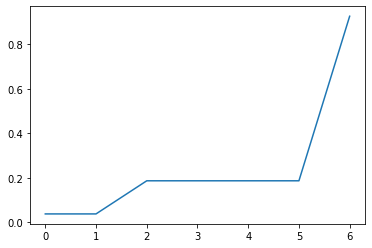

In [59]:
d = 10
mu = 3
s = SM_TI_site(d, mu, boundary="open")
s = np.einsum("iikl -> kl", s)
es, vs = np.linalg.eigh(s)
#plt.plot(es)
v = vs[:, -1]

plt.plot(v)

In [16]:
n = 20
d = 2
mu = 0
mpo = SM_TI_layer(n, d, mu, "mpo")
mps = SM_TI_layer(n, d, mu, "mps")

mps.compress()
mps.normalize()
mps.show()
step = 0
while step < 100:
    mps_new = mpo.apply(mps)
    mps_new.compress()
    mps_new.normalize()
    mps_new.show()
    #mps_new *= (mps.H @ mps)/(mps.H @ mps_new)

    overlap = mps_new.H @ mps 
    print(overlap)
    if abs(overlap - 1) <= 1E-15:
        print(f"break at {step}")
        break

    mps = mps_new
    step += 1

 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9964717009146817
 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9997658768641869
 2 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9999775028690073
 2 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
(0.9999974124995078+4.392060907211106e-23j)
 2 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
(0.9999996702559767+5.735455440486842e-22j)
 2 4 5 5 5 5 6 6 6 6 6 6 6 5 5 5 5 4 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
(0.999999954796

# Upper side Distribution

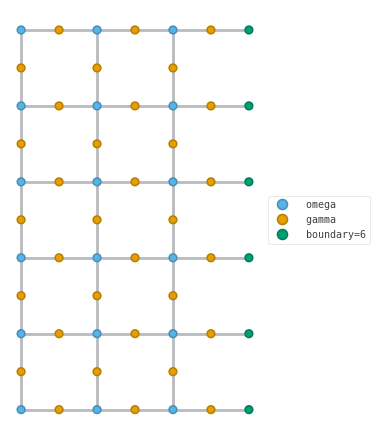

478777744.15728986


AttributeError: 'float' object has no attribute 'data'

In [46]:
ntot = 6; n = (ntot, ntot//2)
d = 2
mu = 1

boundary = [6]*(ntot) #"open"
tn = get_SM_TN(n, d, mu, boundary)
draw_SM_TN(n, tn, boundary)

tnc = tn.contract()
print(tnc)

data = tnc.data[:2, :2, :2, :2, :2, :2]
#print(data)

plt.plot(data.flatten(order="C"))

# Transition tests

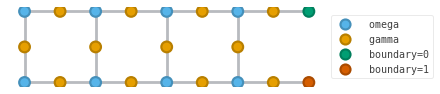

nr=4 done


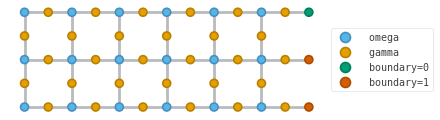

nr=6 done


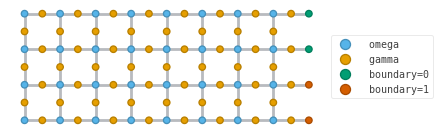

nr=8 done


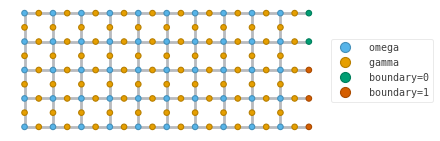

nr=10 done


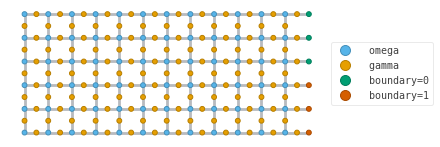

nr=12 done


In [60]:
nr_range = (4, 6, 8, 10, 12)
mu_range = np.linspace(1, 1.5, 51, endpoint=True)
d_range = (10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000)

vals = np.zeros((len(nr_range), len(mu_range), len(d_range)))
for i, nr in enumerate(nr_range):
    for j, mu in enumerate(mu_range):
        for k, d in enumerate(d_range):
            n = (nr//2, nr)

            tn1 = get_SM_TN(n, d, mu, boundary="half")
            tn2 = get_SM_TN(n, d, mu, boundary="full")

            val = tn1.contract()/tn2.contract()
            vals[i, j, k] = -np.log10(val)
            
            #if i == j == 0:
            #    print(d**(1/4))
    draw_SM_TN(n, tn1, "half")

    print(f"nr={nr} done")

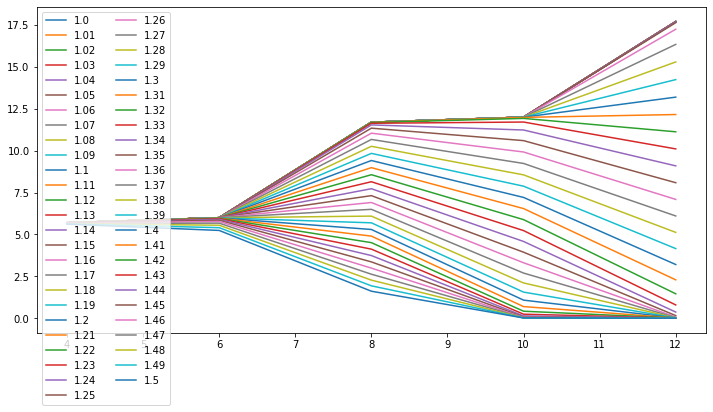

In [63]:
fig = plt.figure(figsize=(12, 6), alpha=0)
fig.patch.set_alpha(1)
plt.plot(nr_range, vals[:, :, 5])
plt.legend(np.round(mu_range, 2), loc="upper left", ncol=2)
#plt.legend(np.round(d_range, 2), loc="upper left", ncol=2)
plt.show()